In [1]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm
import copy


from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

In [2]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
20,12July_gpt2_10dim_12layer_256_RL,linear_regression,Transformer,,-1,-1,10,12,8,12July_gpt2_10dim_12layer_256_RL
22,12July_mlp_10dim_10layer_1024_RL,linear_regression,12July_mlp_10dim_10layer_1024_RL,,-1,-1,10,10,8,12July_mlp_10dim_10layer_1024_RL
25,12July_mlp_10dim_10layer_512_RL,linear_regression,12July_mlp_10dim_10layer_512_RL,,-1,-1,10,10,8,12July_mlp_10dim_10layer_512_RL
21,12July_mlp_10dim_22layer_1024_RL,linear_regression,12July_mlp_10dim_22layer_1024_RL,,-1,-1,10,22,8,12July_mlp_10dim_22layer_1024_RL
23,12July_mlp_10dim_5layer_1024_RL,linear_regression,12July_mlp_10dim_5layer_1024_RL,,-1,-1,10,5,8,12July_mlp_10dim_5layer_1024_RL
...,...,...,...,...,...,...,...,...,...,...
0,pretrained,relu_2nn_regression,Transformer,hidden_layer_size=100,-1,-1,20,12,8,relu_2nn_regression_pretrained
133,pretrained,sparse_linear_regression,Transformer,sparsity=3,-1,-1,20,12,8,sparse_regression_pretrained
136,2d36bb71-76c1-49f4-ba6e-f0a35a42d185,test,test,,-1,100,20,10,8,test
137,e198f433-04f9-4e4b-a492-82b1dc625c9c,test,test,,-1,-1,20,10,8,test


linear_regression_pretrained pretrained


100%|██████████| 15/15 [00:00<00:00, 98922.26it/s]


6Aug_lstm_20dim_9layer_256_lr1e-4_dropout0.1 6Aug_lstm_20dim_9layer_256_lr1e-4_dropout0.1


100%|██████████| 15/15 [00:00<00:00, 188366.95it/s]


6Aug_lstm_20dim_8layer_256_lr1e-4_dropout0.1 6Aug_lstm_20dim_8layer_256_lr1e-4_dropout0.1


100%|██████████| 15/15 [00:00<00:00, 212549.19it/s]


6Aug_lstm_20dim_7layer_256_lr1e-4_dropout0.1 6Aug_lstm_20dim_7layer_256_lr1e-4_dropout0.1


100%|██████████| 15/15 [00:00<00:00, 211122.68it/s]


6Aug_lstm_20dim_6layer_256_lr1e-4_dropout0.1 6Aug_lstm_20dim_6layer_256_lr1e-4_dropout0.1


100%|██████████| 15/15 [00:00<00:00, 193583.26it/s]


6Aug_lstm_20dim_5layer_256_lr1e-4_dropout0.1 6Aug_lstm_20dim_5layer_256_lr1e-4_dropout0.1


100%|██████████| 15/15 [00:00<00:00, 213995.10it/s]


7Aug_lstm_20dim_10layer_256_lr0.0001_dropout0.1 7Aug_lstm_20dim_10layer_256_lr0.0001_dropout0.1


100%|██████████| 15/15 [00:00<00:00, 229615.18it/s]


dict_keys(['half_subspace', 'noisyLR', 'orthogonal_train_test', 'overlapping_train_test', 'random_quadrants', 'scale-x=0.333', 'scale-x=0.5', 'scale-x=2', 'scale-x=3', 'scale-y=0.333', 'scale-y=0.5', 'scale-y=2', 'scale-y=3', 'skewed', 'standard'])
{'half_subspace': {'Transformer': {'mean': [0.9632429122924805, 0.9123161315917969, 0.7510465145111084, 0.6924034118652344, 0.6116585731506348, 0.4950979232788086, 0.39366726875305175, 0.31080701351165774, 0.20295586585998535, 0.1035406231880188, 0.03663731813430786, 0.011795975267887115, 0.005011618882417679, 0.003079252317547798, 0.0027918219566345215, 0.002493770234286785, 0.0021976608783006667, 0.002169094420969486, 0.0019014213234186173, 0.0015295283868908883, 0.0013808086514472961, 0.0011476188898086547, 0.0011712506413459778, 0.001076708547770977, 0.0009131195954978466, 0.0008459294214844704, 0.0006800353527069092, 0.0005611887201666832, 0.0005421477369964122, 0.0004785127006471157, 0.00043568005785346033, 0.0004106187727302313, 0.000

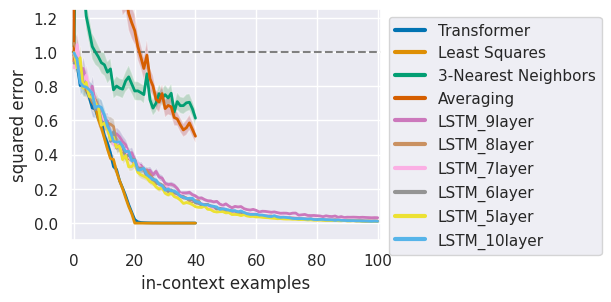

In [3]:
task = "linear_regression"
base_id = "pretrained"
expt_ids = {
    "LSTM_9layer": "6Aug_lstm_20dim_9layer_256_lr1e-4_dropout0.1",
    "LSTM_8layer": "6Aug_lstm_20dim_8layer_256_lr1e-4_dropout0.1",
    "LSTM_7layer": "6Aug_lstm_20dim_7layer_256_lr1e-4_dropout0.1",
    "LSTM_6layer": "6Aug_lstm_20dim_6layer_256_lr1e-4_dropout0.1",
    "LSTM_5layer": "6Aug_lstm_20dim_5layer_256_lr1e-4_dropout0.1",
    "LSTM_10layer": "7Aug_lstm_20dim_10layer_256_lr0.0001_dropout0.1",
}
models = ["Transformer", "Least Squares", "3-Nearest Neighbors", "Averaging"]
for key in expt_ids.keys(): 
   models.append(key)

base_path = os.path.join(run_dir, task, base_id)
expt_paths = {key: os.path.join(run_dir, task, expt_id) for key, expt_id in expt_ids.items()}

def valid_row(r, run_id):
    return r.task == task and r.run_id == run_id

def keep_before_underscore(s):
    if "_" in s:
        return s.split("_")[0]
    return s

metrics_base = collect_results(run_dir, df, valid_row=lambda r: valid_row(r, base_id))
metrics_expts = {key: collect_results(run_dir, df, valid_row=lambda r: valid_row(r, expt_id)) for key, expt_id in expt_ids.items()}

_, conf = get_model_from_run(base_path, only_conf=True)
n_dims = conf.model.n_dims

metrics = copy.deepcopy(metrics_base)

for key in metrics.keys():
    for expt_key, expt_metrics in metrics_expts.items():
        metrics[key][expt_key] = expt_metrics[key][keep_before_underscore(expt_key)]
print(metrics.keys())
print(metrics)

basic_plot(metrics["standard"], models=models)
plt.show()


linear_regression_pretrained pretrained


100%|██████████| 15/15 [00:00<00:00, 115228.13it/s]


29Aug_MultiLayerLSTM_lstm_20dim_5layer_512_lr0.0001_dropout0_curriculumFalse_p_embeddingFalse 29Aug_MultiLayerLSTM_lstm_20dim_5layer_512_lr0.0001_dropout0_curriculumFalse_p_embeddingFalse


100%|██████████| 15/15 [00:00<00:00, 118706.72it/s]


25Aug_5layer_droupout0_run5_lstm_20dim_5layer_512_lr0.0001_dropout0_curriculumFalse_p_embeddingFalse 25Aug_5layer_droupout0_run5_lstm_20dim_5layer_512_lr0.0001_dropout0_curriculumFalse_p_embeddingFalse


100%|██████████| 15/15 [00:00<00:00, 95469.74it/s]


dict_keys(['half_subspace', 'noisyLR', 'orthogonal_train_test', 'overlapping_train_test', 'random_quadrants', 'scale-x=0.333', 'scale-x=0.5', 'scale-x=2', 'scale-x=3', 'scale-y=0.333', 'scale-y=0.5', 'scale-y=2', 'scale-y=3', 'skewed', 'standard'])
{'half_subspace': {'Transformer': {'mean': [0.9632429122924805, 0.9123161315917969, 0.7510465145111084, 0.6924034118652344, 0.6116585731506348, 0.4950979232788086, 0.39366726875305175, 0.31080701351165774, 0.20295586585998535, 0.1035406231880188, 0.03663731813430786, 0.011795975267887115, 0.005011618882417679, 0.003079252317547798, 0.0027918219566345215, 0.002493770234286785, 0.0021976608783006667, 0.002169094420969486, 0.0019014213234186173, 0.0015295283868908883, 0.0013808086514472961, 0.0011476188898086547, 0.0011712506413459778, 0.001076708547770977, 0.0009131195954978466, 0.0008459294214844704, 0.0006800353527069092, 0.0005611887201666832, 0.0005421477369964122, 0.0004785127006471157, 0.00043568005785346033, 0.0004106187727302313, 0.000

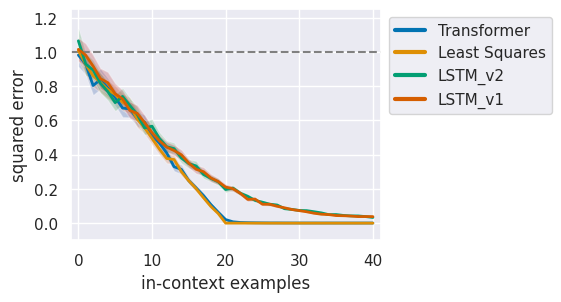

In [4]:
task = "linear_regression"
base_id = "pretrained"
expt_ids = {
"LSTM_v2": "29Aug_MultiLayerLSTM_lstm_20dim_5layer_512_lr0.0001_dropout0_curriculumFalse_p_embeddingFalse",
"LSTM_v1": "25Aug_5layer_droupout0_run5_lstm_20dim_5layer_512_lr0.0001_dropout0_curriculumFalse_p_embeddingFalse",
}


models = ["Transformer", "Least Squares", ]
for key in expt_ids.keys(): 
   models.append(key)

base_path = os.path.join(run_dir, task, base_id)
expt_paths = {key: os.path.join(run_dir, task, expt_id) for key, expt_id in expt_ids.items()}

def valid_row(r, run_id):
    return r.task == task and r.run_id == run_id

def keep_before_underscore(s):
    if "_" in s:
        return s.split("_")[0]
    return s

metrics_base = collect_results(run_dir, df, valid_row=lambda r: valid_row(r, base_id))
metrics_expts = {key: collect_results(run_dir, df, valid_row=lambda r: valid_row(r, expt_id)) for key, expt_id in expt_ids.items()}

_, conf = get_model_from_run(base_path, only_conf=True)
n_dims = conf.model.n_dims

metrics = copy.deepcopy(metrics_base)

for key in metrics.keys():
    for expt_key, expt_metrics in metrics_expts.items():
        metrics[key][expt_key] = expt_metrics[key][keep_before_underscore(expt_key)]
print(metrics.keys())
print(metrics)

basic_plot(metrics["standard"], models=models)
plt.show()


DEBUG: models ['Transformer', 'Least Squares', 'LSTM_v2', 'LSTM_v1']
DEBUG: metrics {'Transformer': {'mean': [0.9632429122924805, 0.9123161315917969, 0.7510465145111084, 0.6924034118652344, 0.6116585731506348, 0.4950979232788086, 0.39366726875305175, 0.31080701351165774, 0.20295586585998535, 0.1035406231880188, 0.03663731813430786, 0.011795975267887115, 0.005011618882417679, 0.003079252317547798, 0.0027918219566345215, 0.002493770234286785, 0.0021976608783006667, 0.002169094420969486, 0.0019014213234186173, 0.0015295283868908883, 0.0013808086514472961, 0.0011476188898086547, 0.0011712506413459778, 0.001076708547770977, 0.0009131195954978466, 0.0008459294214844704, 0.0006800353527069092, 0.0005611887201666832, 0.0005421477369964122, 0.0004785127006471157, 0.00043568005785346033, 0.0004106187727302313, 0.00037038370501250026, 0.0003815237432718277, 0.00034064881037920713, 0.00035692304372787477, 0.00038688082713633776, 0.0004218162037432194, 0.0003627842292189598, 0.00038797049783170225,

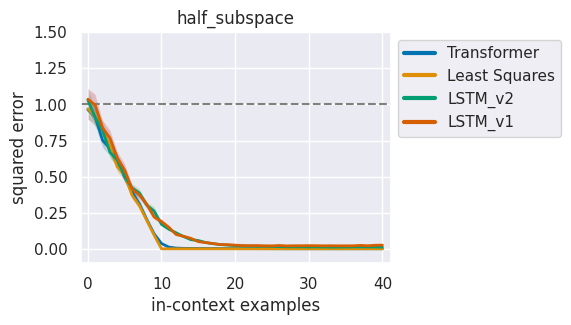

DEBUG: models ['Transformer', 'Least Squares', 'LSTM_v2', 'LSTM_v1']
DEBUG: metrics {'Transformer': {'mean': [0.9622732162475586, 1.0275540351867676, 0.9141025543212891, 0.8694589614868165, 0.8028970718383789, 0.7154922485351562, 0.7076632022857666, 0.7064539909362793, 0.7439779758453369, 0.612362289428711, 0.5695746421813965, 0.5196301460266113, 0.5218579292297363, 0.47569832801818845, 0.45649051666259766, 0.46550493240356444, 0.49918327331542967, 0.5127709865570068, 0.6197527885437012, 0.7753526210784912, 0.9675973892211914, 0.757837963104248, 0.5452767848968506, 0.410020112991333, 0.322327184677124, 0.27910263538360597, 0.2696341276168823, 0.2369563102722168, 0.1989450454711914, 0.18814512491226196, 0.1876662015914917, 0.16887385845184327, 0.16822760105133056, 0.1655745267868042, 0.1599364995956421, 0.15338915586471558, 0.1477346658706665, 0.14619187116622925, 0.14670875072479247, 0.1326284646987915, 0.1315389633178711], 'std': [1.3823281288146974, 1.588482666015625, 1.3455718040466

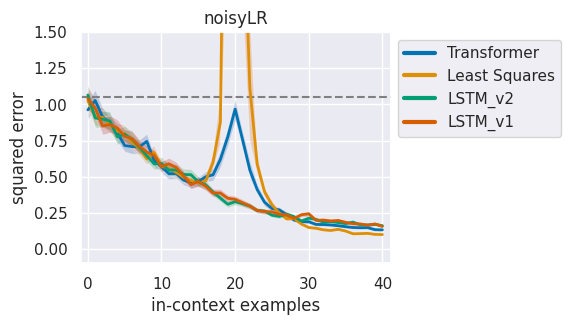

DEBUG: models ['Transformer', 'Least Squares', 'LSTM_v2', 'LSTM_v1']
DEBUG: metrics {'Transformer': {'mean': [1.0217679977416991, 0.9623150825500488, 1.0113537788391114, 0.9524394989013671, 0.9380861282348633, 1.0286196708679198, 1.0361715316772462, 0.9707786560058593, 1.0409666061401368, 1.0015620231628417, 1.0454618453979492, 1.053307342529297, 0.9913642883300782, 0.971368408203125, 0.9544370651245118, 0.9848331451416016, 0.9928735733032227, 0.9759233474731446, 1.0048845291137696, 0.9897491455078125, 0.0005352805368602276, 0.0004169079475104809, 0.0003511696355417371, 0.0002875896403566003, 0.0002620419953018427, 0.000222720461897552, 0.00018406048184260726, 0.0001728493021801114, 0.00014920710818842054, 0.00012199145276099443, 0.00012832792708650231, 0.00011993589578196406, 0.00011988093610852957, 0.00011454259511083365, 0.00010690081398934126, 0.00010612003970891237, 0.00010373826371505857, 0.00010288555640727281, 0.00010334390681236983, 0.00010946926195174456, 0.000107717351056635

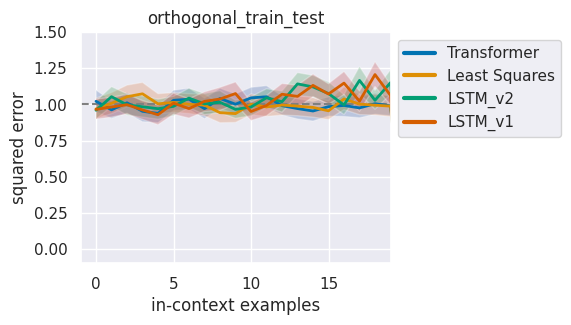

DEBUG: models ['Transformer', 'Least Squares', 'LSTM_v2', 'LSTM_v1']
DEBUG: metrics {'Transformer': {'mean': [0.940831184387207, 0.0014987039379775525, 0.00114749725908041, 0.001114297192543745, 0.0011458348482847214, 0.001237800158560276, 0.0012612286023795604, 0.0012674537487328053, 0.0013417397625744344, 0.001378537993878126, 0.0014556750655174255, 0.0015683272853493691, 0.001348533295094967, 0.001462874375283718, 0.001420062966644764, 0.0013022067956626414, 0.001177257765084505, 0.0011843990534543992, 0.001114772167056799, 0.0011945923790335656, 0.0011577241122722626, 0.0010638293810188771, 0.0010684968903660775, 0.0009141969494521618, 0.0008212359622120857, 0.0007396721746772527, 0.0007711728103458881, 0.0006737171672284604, 0.0006362859159708024, 0.0005957374814897776, 0.0006055089645087719, 0.0005502159707248211, 0.0005313376896083355, 0.0005777932703495026, 0.0005565131548792123, 0.0005112075712531805, 0.0004702399484813213, 0.0005347360391169786, 0.0004997621290385723, 0.00049

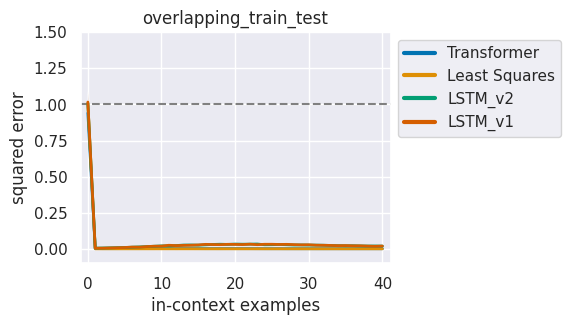

DEBUG: models ['Transformer', 'Least Squares', 'LSTM_v2', 'LSTM_v1']
DEBUG: metrics {'Transformer': {'mean': [0.9723726272583008, 0.9021141052246093, 0.8317445755004883, 0.8343681335449219, 0.7415112495422364, 0.7858212471008301, 0.6827107429504394, 0.6362492561340332, 0.6094096660614013, 0.49908981323242185, 0.49320411682128906, 0.4823903560638428, 0.3757808208465576, 0.3574350357055664, 0.32669188976287844, 0.2657474040985107, 0.21822092533111573, 0.15746629238128662, 0.1263405442237854, 0.08828676342964173, 0.061741971969604494, 0.05009779930114746, 0.03234137892723084, 0.02356511652469635, 0.019423671066761017, 0.013550607860088349, 0.012008891254663468, 0.010178913921117782, 0.00837375521659851, 0.007862187922000885, 0.006296417117118836, 0.005905334278941155, 0.005831588432192803, 0.006172683089971542, 0.004725147411227227, 0.00439193807542324, 0.004311689734458923, 0.004060768708586693, 0.004432310909032821, 0.0036802392452955244, 0.003953025490045547], 'std': [1.428069210052490

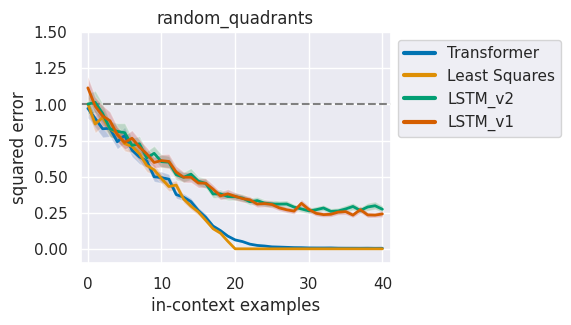

DEBUG: models ['Transformer', 'Least Squares', 'LSTM_v2', 'LSTM_v1']
DEBUG: metrics {'Transformer': {'mean': [0.11263935565948487, 0.1052499532699585, 0.10878870487213135, 0.09428604841232299, 0.08878390192985534, 0.08304386138916016, 0.0813037097454071, 0.07626004219055176, 0.062307482957839964, 0.06446815729141235, 0.05849922895431518, 0.057972317934036253, 0.060966843366622926, 0.06666772365570069, 0.06739245057106018, 0.06645221710205078, 0.07332061529159546, 0.06897982358932495, 0.07819283604621888, 0.07393417954444885, 0.09180535078048706, 0.08656083941459655, 0.07002841234207154, 0.06466649174690246, 0.057602882385253906, 0.07253302335739135, 0.06883457899093628, 0.06765939593315125, 0.06535385847091675, 0.06312512159347534, 0.06273844838142395, 0.05302093625068664, 0.04964370727539062, 0.0469857394695282, 0.049150675535202026, 0.042860060930252075, 0.03676023185253143, 0.04045611023902893, 0.031177154183387755, 0.034563034772872925, 0.032723888754844666], 'std': [0.160910522937

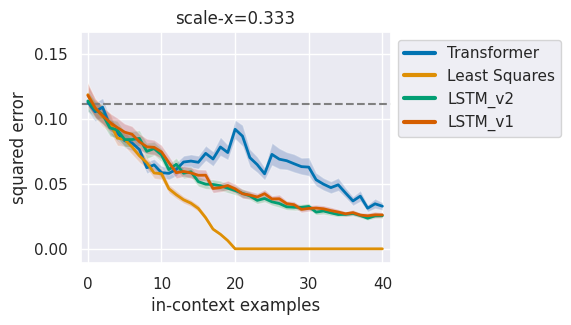

DEBUG: models ['Transformer', 'Least Squares', 'LSTM_v2', 'LSTM_v1']
DEBUG: metrics {'Transformer': {'mean': [0.26132521629333494, 0.2314812183380127, 0.22462904453277588, 0.22001609802246094, 0.2104645252227783, 0.18403265476226807, 0.1861415147781372, 0.16458022594451904, 0.1521817684173584, 0.14577999114990234, 0.1284816861152649, 0.11509463787078858, 0.0988670527935028, 0.0838518738746643, 0.07667464017868042, 0.06832257509231568, 0.058275872468948366, 0.049827557802200315, 0.04519710540771484, 0.0397896945476532, 0.03835000991821289, 0.0251502126455307, 0.019971027970314026, 0.015980960428714754, 0.009741304069757461, 0.008628240972757339, 0.008496088534593582, 0.007617680728435517, 0.00693863034248352, 0.005528637021780014, 0.005279135704040527, 0.005229421705007553, 0.004985390231013298, 0.004106765985488892, 0.004219724610447883, 0.004021129757165909, 0.0035730734467506408, 0.0036132495850324632, 0.0030645102262496947, 0.002923625707626343, 0.0033733434975147247], 'std': [0.401

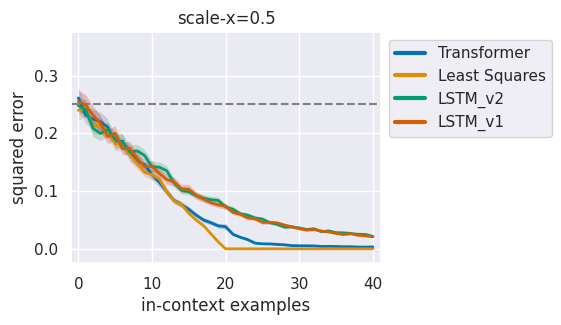

DEBUG: models ['Transformer', 'Least Squares', 'LSTM_v2', 'LSTM_v1']
DEBUG: metrics {'Transformer': {'mean': [3.8108863830566406, 3.7467414855957033, 3.3756172180175783, 3.3391143798828127, 3.2795654296875, 3.1881969451904295, 2.852968215942383, 2.685258483886719, 2.584675598144531, 2.3638422012329103, 2.0083124160766603, 2.036523628234863, 1.728397750854492, 1.6961437225341798, 1.4508331298828125, 1.3448893547058105, 1.114530372619629, 0.9832470893859864, 1.0469706535339356, 0.7757928371429443, 0.7101222038269043, 0.6044591426849365, 0.5471387386322022, 0.4557938098907471, 0.42403254508972166, 0.39744930267333983, 0.3612881898880005, 0.3200347900390625, 0.2699571132659912, 0.23468937873840331, 0.2514296293258667, 0.20341148376464843, 0.1788333535194397, 0.1984223961830139, 0.1855767011642456, 0.1812267541885376, 0.15858099460601807, 0.18952928781509398, 0.17169761657714844, 0.17498867511749266, 0.1701072335243225], 'std': [5.442247009277343, 5.764129257202148, 4.997257995605469, 4.746

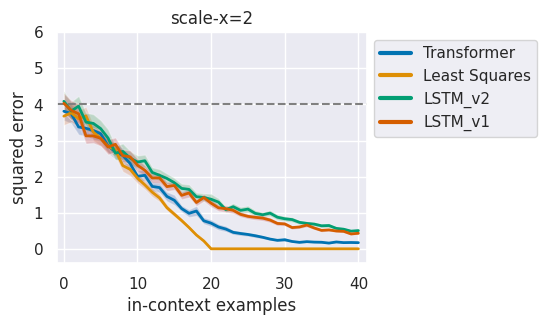

DEBUG: models ['Transformer', 'Least Squares', 'LSTM_v2', 'LSTM_v1']
DEBUG: metrics {'Transformer': {'mean': [8.363350677490235, 9.056748199462891, 8.72424087524414, 8.497202301025391, 8.47382049560547, 8.525755310058594, 8.951703643798828, 8.178002166748048, 7.7466278076171875, 7.1440589904785154, 7.451252746582031, 7.257946014404297, 7.026573181152344, 7.131730651855468, 7.1393287658691404, 7.131278228759766, 6.83177490234375, 6.803401184082031, 6.69366683959961, 7.104339599609375, 6.895304870605469, 6.954570770263672, 7.44923095703125, 7.15203628540039, 6.958148193359375, 6.979661560058593, 6.567128753662109, 6.458769226074219, 6.7116142272949215, 5.796712493896484, 6.223550415039062, 5.911818313598633, 6.160560226440429, 5.659481048583984, 5.4288898468017575, 5.813561248779297, 5.173865890502929, 5.073271560668945, 4.987874221801758, 4.985746002197265, 5.250712966918945], 'std': [13.582325744628907, 13.449751281738282, 12.82476806640625, 12.877474975585937, 13.783816528320312, 13.2

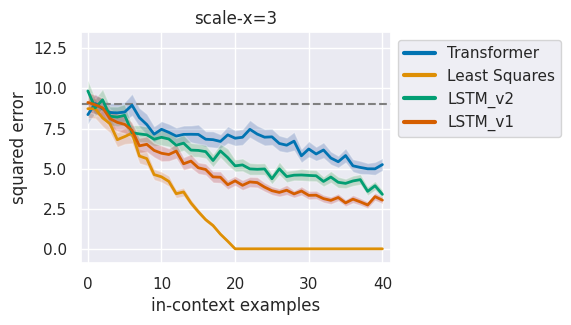

DEBUG: models ['Transformer', 'Least Squares', 'LSTM_v2', 'LSTM_v1']
DEBUG: metrics {'Transformer': {'mean': [0.11549080610275268, 0.10805983543395996, 0.10165340900421142, 0.0966391921043396, 0.08559033274650574, 0.08194503784179688, 0.07813478112220765, 0.07779597043991089, 0.06637449860572815, 0.054783213138580325, 0.05676696300506592, 0.053928029537200925, 0.05098389983177185, 0.04085145890712738, 0.03632102608680725, 0.028708696365356445, 0.023786625266075133, 0.0195330411195755, 0.012717559933662415, 0.0076823137700557705, 0.004195136949419975, 0.001523725688457489, 0.0009323211386799812, 0.0005231701768934726, 0.00039726989343762397, 0.00032756763976067306, 0.0002802065573632717, 0.00023161377757787704, 0.00023346529342234136, 0.00021350146271288396, 0.0001901243580505252, 0.00017933065537363292, 0.00015948578948155046, 0.00016595773631706835, 0.00015940781449899077, 0.00014826547121629118, 0.0001537959324195981, 0.00013868813402950764, 0.0001416011364199221, 0.00014938372187316

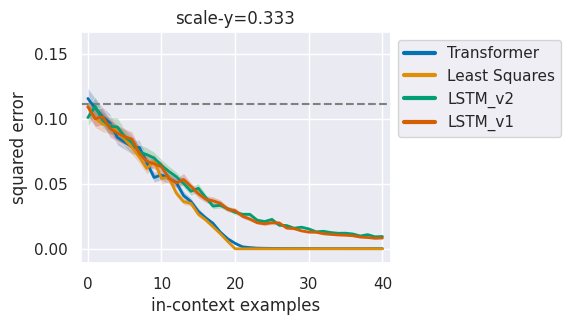

DEBUG: models ['Transformer', 'Least Squares', 'LSTM_v2', 'LSTM_v1']
DEBUG: metrics {'Transformer': {'mean': [0.27016620635986327, 0.2323958158493042, 0.2443772077560425, 0.2155749797821045, 0.19334783554077148, 0.18856691122055053, 0.1711963891983032, 0.16011664867401124, 0.14373611211776732, 0.13321586847305297, 0.126874840259552, 0.10924004316329956, 0.09990178942680358, 0.08682916760444641, 0.07767063975334168, 0.05334171652793884, 0.05108059048652649, 0.03426468968391418, 0.02665106952190399, 0.01624525785446167, 0.007001683861017227, 0.003145839646458626, 0.0014108547940850258, 0.0007925203070044517, 0.0006176239345222712, 0.00046148309484124185, 0.0004055507481098175, 0.0003768295049667358, 0.0003065489465370774, 0.0003192091826349497, 0.0003051817649975419, 0.00024140032473951578, 0.0002446077298372984, 0.00025985694956034424, 0.00024580010212957857, 0.00023599821142852306, 0.00023108171299099923, 0.00020793227013200523, 0.00021493623498827218, 0.00022007604129612446, 0.0002059

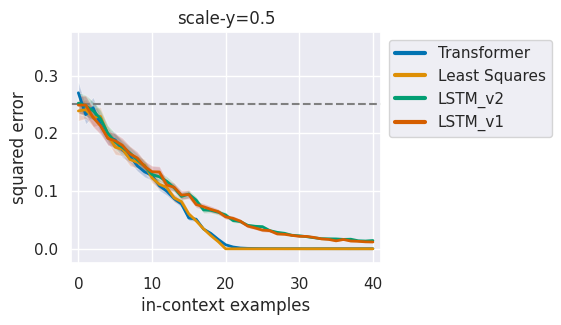

DEBUG: models ['Transformer', 'Least Squares', 'LSTM_v2', 'LSTM_v1']
DEBUG: metrics {'Transformer': {'mean': [3.884858322143555, 3.5958580017089843, 3.9473400115966797, 3.1379764556884764, 3.415779876708984, 2.9435070037841795, 2.8754642486572264, 2.7411340713500976, 2.3988285064697266, 2.3458337783813477, 2.0143075942993165, 1.788376235961914, 1.6158012390136718, 1.4496881484985351, 1.1748419761657716, 0.9838897705078125, 0.8644155502319336, 0.5919861793518066, 0.39805283546447756, 0.27087883949279784, 0.12296416759490966, 0.08155436515808105, 0.038664957880973815, 0.024015405774116518, 0.020281748473644258, 0.012737059593200683, 0.015109120309352875, 0.011237005144357682, 0.022356510162353516, 0.009734396636486054, 0.010049118846654891, 0.009475813806056976, 0.009481707960367203, 0.009109693765640258, 0.009528668224811554, 0.009279845654964447, 0.008180129528045654, 0.0076809443533420564, 0.007245028018951416, 0.00935174971818924, 0.0065199598670005795], 'std': [5.594132995605468, 5.

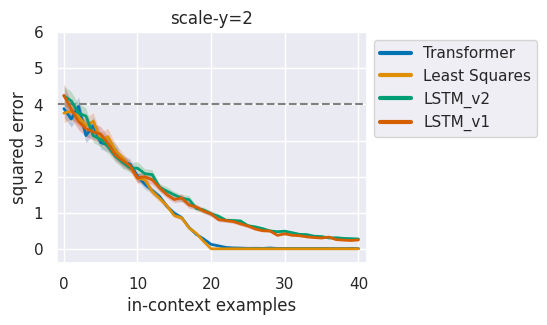

DEBUG: models ['Transformer', 'Least Squares', 'LSTM_v2', 'LSTM_v1']
DEBUG: metrics {'Transformer': {'mean': [8.735563659667969, 8.629513549804688, 8.3698974609375, 8.144062042236328, 6.867694091796875, 7.353468322753907, 6.60435791015625, 5.634857177734375, 5.362101364135742, 5.400809860229492, 4.623461532592773, 4.662681579589844, 3.802836227416992, 3.450788879394531, 2.6795785903930662, 2.4961469650268553, 2.130075454711914, 1.6558345794677733, 1.239729118347168, 1.0048139572143555, 0.7813796997070312, 0.5589460849761962, 0.43280415534973143, 0.3910136461257935, 0.27915453910827637, 0.2925879955291748, 0.2912109136581421, 0.36824238300323486, 0.2597254753112793, 0.25039670467376707, 0.30399794578552247, 0.2597480535507202, 0.1835322141647339, 0.2714396476745605, 0.22619597911834716, 0.212664794921875, 0.23559203147888183, 0.26570839881896974, 0.2382401704788208, 0.2542322874069214, 0.25000524520874023], 'std': [13.346243286132813, 12.578438568115235, 12.93209228515625, 11.7063041687

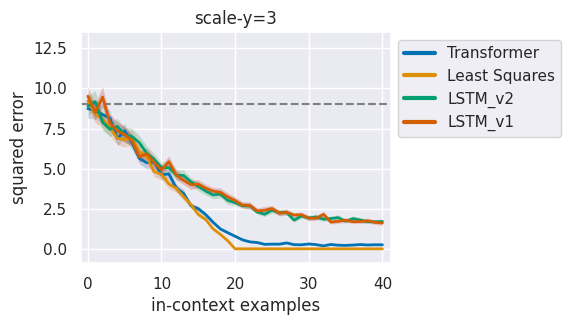

DEBUG: models ['Transformer', 'Least Squares', 'LSTM_v2', 'LSTM_v1']
DEBUG: metrics {'Transformer': {'mean': [1.0172086715698243, 0.6402848720550537, 0.5014616489410401, 0.3776614427566528, 0.31359572410583497, 0.2116999626159668, 0.18059089183807372, 0.15971052646636963, 0.1399226188659668, 0.11061776876449585, 0.1028898000717163, 0.11127077341079712, 0.10663849115371704, 0.1094159483909607, 0.1145581603050232, 0.11590192317962647, 0.09470928311347962, 0.10462424755096436, 0.10046427249908448, 0.14134728908538818, 0.11887277364730835, 0.11603138446807862, 0.12148859500885009, 0.10129406452178955, 0.11050920486450196, 0.11128654479980468, 0.12795674800872803, 0.12330986261367798, 0.1367938280105591, 0.14273830652236938, 0.14310156106948851, 0.11852085590362549, 0.13730885982513427, 0.11852630376815795, 0.15389941930770873, 0.11677205562591553, 0.10656915903091431, 0.12296102046966553, 0.1085016131401062, 0.09641695022583008, 0.12826961278915405], 'std': [2.2705738067626955, 1.188039779

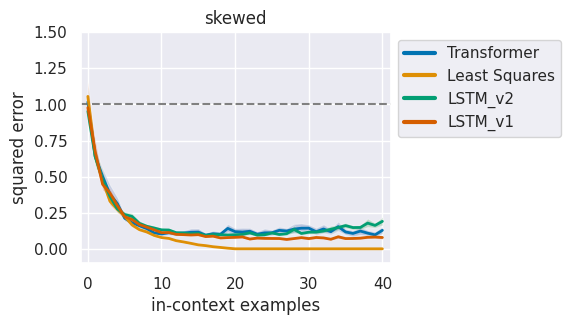

In [5]:
# plot any OOD metrics
for name, metric in metrics.items():
    if name == "standard": continue
   
    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    ax.set_title(name)
    
    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)

    plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [6]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [7]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

NameError: name 'run_path' is not defined

In [ ]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)

In [ ]:
with torch.no_grad():

    pred = model(xs, ys)

In [ ]:
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [ ]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2)
with torch.no_grad():
    pred2 = model(xs2, ys2)

In [ ]:
loss2 = metric(pred2, ys2).numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.